For this project, we'll be performing some Exploratory Data Analysis on our dataset. The dataset is a collection of public information from Lorain County Ohio, USA about Criminal Data. Primarily we will focus on drug-related crimes, and alcohol-related crimes.

In [0]:
# Importing Dependencies
import os
import time
import folium
import datetime
import traceback
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import drive
from collections import Counter

def warn(*args, **kwargs): pass
import warnings
warnings.warn = warn
from sklearn.preprocessing import LabelEncoder

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# The features of our dataset are as follows:
  
'name' = 'The name of the individual'
'dob' = 'Date Of Birth'
'party' = Plaintiff or Defendant 
'opposition' = ''
'casen'o = case number
'caseid' = case ID
'casetype' =  case type
'versus' = parties involved
'filedate' = date of file
'judge' = overseeing judge
'levels' = felony or misdemeanor, levels 1-5
'str_offs' = string collection of offenses
'orig_offs' = offenses as collected
'str_addresses' = collected home addresses of each defending indiviual
'party_name_dob_type_addr_atty_by"**"then",,""' = 

# Engineered Features
'zipcode' = zipcode of the home address of the individual

In [0]:
columns = [
    'name',
    'age',
    'zipcode',
    'dob',
##    'street',    
    'party',
    'opposition',
    'caseno',
    'caseid',
    'casetype',
    'versus',
    'filedate',
    'judge',
    'levels',
    'str_offs',
    'orig_offs',
    'str_addresses',
    'party_name_dob_type_addr_atty_by"**"then",,"'
    ]


# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
link = 'https://drive.google.com/open?id=1sqRnAqN0hCkGQb9xmjkL3dBUcnyAL1mq'
myid = link.split('=')[1]
downloaded = drive.CreateFile({'id':myid}) 
downloaded.GetContentFile('xoutput.csv') 

In [3]:
# opening the dataframe, limitit to events that occurred in 2010 and later
# for every zipcode in list_addresses, there is a new row for that zipcode.
# so the number of rows may by multiplicatively greater than the number
# of actual instances

df_original = pd.read_csv('xoutput.csv').dropna()
df_original = df_original.applymap(lambda s:s.lower() if type(s) == str else s)
df_original = df_original[df_original.zipcode.str.isnumeric()]
df_original['zipcode'] = df_original['zipcode'].astype(str)
df_original['versus'] = df_original['versus'].apply(
    lambda s:s.replace('state of ','').split(' v')[0])
df_original['age'] = df_original['age'].astype(str)
df_original['age_decade'] = df_original['age'].apply(
    lambda s:s[0])
df_original['age'] = df_original['age'].astype(int)

df_drugs = df_original[df_original.orig_offs.str.contains('drug')]
df_alcohol = df_original[df_original.orig_offs.str.contains('alcohol')]

print()
print('dataframe 2010+:')
print(df_original.shape)

print()
print('df_drugs:')
print(df_drugs.shape)

print()
print('df_alcohol:')
print(df_alcohol.shape)


dataframe 2010+:
(10908, 29)

df_drugs:
(3695, 29)

df_alcohol:
(533, 29)


In [4]:
list_columns = df_drugs.columns.tolist()
for column in list_columns:
  print()
  print(column)
  print(df_drugs[column].value_counts()[:6])


name
brown, edward l    54
green, keeon a     40
hayes, eric m      39
cruz, eddie a      36
davis, elonzo d    26
hodge, edward      26
Name: name, dtype: int64

age
37    208
29    196
34    196
32    192
30    164
25    150
Name: age, dtype: int64

zipcode
44035    1387
44052    1036
44001     290
44011     134
44039     116
44140     109
Name: zipcode, dtype: int64

zipcodepopulation
63572    1387
28620    1036
20862     290
22538     134
32509     116
15426     109
Name: zipcodepopulation, dtype: int64

dob
4/28/1982     56
10/12/1982    54
4/20/1984     52
6/1/1971      39
2/27/1985     39
10/30/1986    36
Name: dob, dtype: int64

party
d    3695
Name: party, dtype: int64

opposition
state of ohio             3692
lorain municipal court       3
Name: opposition, dtype: int64

caseno
10cr081790    18
12cr084308    18
17cr097609    18
14cr089911    18
12cr084853    18
18cr099061    18
Name: caseno, dtype: int64

caseid
335350    18
386717    18
258529    18
290055    18
270709    

In [5]:
list_judges = df_drugs.judge.tolist()
list_totallevels = []
list_levelsets = df_drugs.levels.tolist()
for i in list_levelsets:
  levels = i.split(';')
  for level in levels: 
    list_totallevels.append(level.strip())
c_total = Counter(list_totallevels)


dct_judges = {}
list_l = []
for judge in list(sorted(set(list_judges))):
  list_lvls = []
  judgename = judge.replace(' judge ','').strip()
  df_judge = df_drugs[df_drugs.judge==judge]
  list_judgelevelsets = df_judge.levels.tolist()

  for levelset in list_judgelevelsets:
    list_levels = levelset.split(';')
    for level in list_levels:
      list_lvls.append(level.strip())
  c_judge = Counter(list_lvls).most_common(100)

  for i in c_judge:
    #   print(judgename)
    #   input(i)
    lvl = i[0]
    lvlcnt = i[1]
    totalforthislevel = c_total[lvl]

    list_l.append([lvlcnt, totalforthislevel, lvlcnt/totalforthislevel, lvl, judgename])
list_l = sorted(list_l, reverse=True)

print('df_drugs: ' + str(df_drugs.shape))
print(c_total)
print(', '.join(['lvl.cnt', 'lvl.ttl', 'lvl.ttl.pct', 'lvl.name', 'judge']))
for i in list_l[:10]: print(i)
  
# 'level percentage of judges cases'
# 'level percentage compared to other judges'
# 'based on the judge and charge, what lvl is an individual most likely to receive'
# 'find anomolies of how out-of-character a person is charged, and see if its because the person is related to law enforcement. like miraldi son.'

df_drugs: (3695, 29)
Counter({'f5': 3464, 'm4': 1704, 'f4': 1417, 'm1': 1297, 'f3': 1140, 'm2': 706, 'f2': 432, 'f1': 357})
lvl.cnt, lvl.ttl, lvl.ttl.pct, lvl.name, judge
[640, 3464, 0.18475750577367206, 'f5', 'betleski,mark']
[618, 3464, 0.1784064665127021, 'f5', 'miraldi,james']
[581, 3464, 0.16772517321016167, 'f5', 'rothgery,christopher']
[490, 3464, 0.14145496535796767, 'f5', 'ewers,raymond']
[433, 3464, 0.125, 'f5', 'miraldi,john']
[310, 1704, 0.18192488262910797, 'm4', 'rothgery,christopher']
[302, 1704, 0.1772300469483568, 'm4', 'miraldi,james']
[288, 1417, 0.20324629498941427, 'f4', 'betleski,mark']
[285, 3464, 0.08227482678983834, 'f5', 'burge,james']
[267, 1704, 0.15669014084507044, 'm4', 'ewers,raymond']


In [0]:


# # Which cities have the highest percentage of offenses
# # in relationship to the number of people in its population?

# list_list_ethnicities = [
#     [cityname, ethnicity_percentage, offenders_per_person]
# ]

37    208
29    196
34    196
32    192
30    164
25    150
48    140
28    139
27    128
33    128
Name: age, dtype: int64


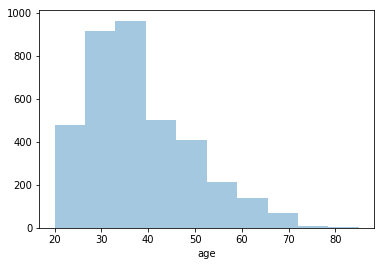

In [7]:
# Visualizing the distribution of each frame by age
print(df_drugs.age.value_counts()[:10])
s1 = sns.distplot(df_drugs.age, bins=10, kde=False);

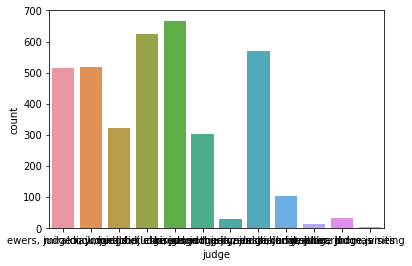

In [8]:
# Visualizing by the Judge
s2 = sns.countplot(x="judge", data=df_drugs)

In [9]:
# Visualizing by Zipcode
zipcount = df_drugs.zipcode.value_counts()[:10]
zipindex = df_drugs.zipcode.value_counts().index.tolist()
list_zipdata = []
for i in range(len(zipcount)):
  zipcode = zipindex[i]
  count_offenders = zipcount[zipcode]
  zipcode_population = df_drugs[df_drugs.zipcode==zipindex[i]].zipcodepopulation.tolist()[0]
  offenders_per_population = count_offenders/zipcode_population
  itemdetails = [offenders_per_population, zipcode, count_offenders, zipcode_population]
  list_zipdata.append(itemdetails)
  
list_zipdata = sorted(list_zipdata,reverse=True)
print('offenders_per_population, zipcode, count_offenders, zipcode_population')
for i in list_zipdata: print(i)

offenders_per_population, zipcode, count_offenders, zipcode_population
[0.036198462613556956, '44052', 1036, 28620]
[0.02181778141320078, '44035', 1387, 63572]
[0.013900872399578181, '44001', 290, 20862]
[0.007065992480228186, '44140', 109, 15426]
[0.005945514242612477, '44011', 134, 22538]
[0.003959300097918174, '44012', 93, 23489]
[0.003568242640499554, '44039', 116, 32509]
[0.0034291477559253657, '44113', 68, 19830]
[0.002562756661623491, '44145', 83, 32387]
[0.0015325430832264723, '44070', 49, 31973]


In [0]:
'visualize correlations between variables?'
'add dummy variables for remaining columns'

list_categorical_columns = [
    'age_decade',
    'zipcode',
    'versus',
    'judge',   
]

df_dummies = pd.get_dummies(df_drugs[list_categorical_columns])

dfd = df_drugs[[
    'f1',
    'f2',
    'f3',
    'f4',
    'f5',
    'm1',
    'm2',
    'm3',
    'm4',
    'm5',     
]].copy()
df_testdata = pd.concat([dfd, df_dummies], axis=1)

In [11]:
list_levelcolumns = [  
  'f1',
  'f2',
  'f3',
  'f4',
  'f5',
  'm1',
  'm2',
  'm3',
  'm4',
  'm5',
]
    
  
list_classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    NuSVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)


for clf in list_classifiers:
  name = clf.__class__.__name__
  for column in list_levelcolumns:
    try:
      print()
      print("="*30)
      print(name)
      print(column)
      X = np.array(dfd.drop([column], axis=1))
      X = preprocessing.scale(X)
      y = np.array(dfd[column])
      X_train, X_test, y_train, y_test = train_test_split(
          X, y, test_size=0.2, random_state=0)
      classifier = clf
      classifier.fit(X_train, y_train)

      print('****Results****')
      train_predictions = clf.predict(X_test)
      acc = accuracy_score(y_test, train_predictions)
      print("Accuracy: {:.4%}".format(acc))

      train_predictions = clf.predict_proba(X_test)
      ll = log_loss(y_test, train_predictions)
      print("Log Loss: {}".format(ll))
      
      confidence = round(
        classifier.score(X_test, y_test),6)
      print('Logistic Confidence: ' + str(confidence))

      log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
      log = log.append(log_entry)
    
    except: continue


KNeighborsClassifier
f1
****Results****
Accuracy: 95.9405%
Log Loss: 1.046146272241638
Logistic Confidence: 0.959405

KNeighborsClassifier
f2
****Results****
Accuracy: 93.0988%
Log Loss: 1.473387148580849
Logistic Confidence: 0.930988

KNeighborsClassifier
f3
****Results****
Accuracy: 84.0325%
Log Loss: 3.377526440203831
Logistic Confidence: 0.840325

KNeighborsClassifier
f4
****Results****
Accuracy: 81.5968%
Log Loss: 2.741727370656145
Logistic Confidence: 0.815968

KNeighborsClassifier
f5
****Results****
Accuracy: 85.3857%
Log Loss: 1.9398810013493422
Logistic Confidence: 0.853857

KNeighborsClassifier
m1
****Results****
Accuracy: 70.5007%
Log Loss: 7.172020645139285
Logistic Confidence: 0.705007

KNeighborsClassifier
m2
****Results****
Accuracy: 73.7483%
Log Loss: 7.729248229116765
Logistic Confidence: 0.737483

KNeighborsClassifier
m3
****Results****
Accuracy: 100.0000%

KNeighborsClassifier
m4
****Results****
Accuracy: 60.2165%
Log Loss: 2.822784630938453
Logistic Confidence: 0.6

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


****Results****
Accuracy: 93.7754%
Log Loss: 0.12712769477967334
Logistic Confidence: 0.937754

SVC
f2


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


****Results****
Accuracy: 90.3924%
Log Loss: 0.26485100313768445
Logistic Confidence: 0.903924

SVC
f3


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


****Results****
Accuracy: 81.5968%
Log Loss: 0.46256051099239986
Logistic Confidence: 0.815968

SVC
f4


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


****Results****
Accuracy: 83.7618%
Log Loss: 0.43281328491496623
Logistic Confidence: 0.837618

SVC
f5


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


****Results****
Accuracy: 83.8972%
Log Loss: 0.369478295793459
Logistic Confidence: 0.838972

SVC
m1


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


****Results****
Accuracy: 71.8539%
Log Loss: 0.5697943515984051
Logistic Confidence: 0.718539

SVC
m2


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


****Results****
Accuracy: 82.5440%
Log Loss: 0.45175042080807987
Logistic Confidence: 0.82544

SVC
m3

SVC
m4


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


****Results****
Accuracy: 53.7212%
Log Loss: 0.6510013486891938
Logistic Confidence: 0.537212

SVC
m5

NuSVC
f1

NuSVC
f2

NuSVC
f3

NuSVC
f4

NuSVC
f5


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default 

****Results****
Accuracy: 82.9499%
Log Loss: 0.534139163893786
Logistic Confidence: 0.829499

NuSVC
m1


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


****Results****
Accuracy: 73.4777%
Log Loss: 0.5967045468653159
Logistic Confidence: 0.734777

NuSVC
m2

NuSVC
m3

NuSVC
m4


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


****Results****
Accuracy: 62.1110%
Log Loss: 0.6573177298834728
Logistic Confidence: 0.62111

NuSVC
m5

DecisionTreeClassifier
f1
****Results****
Accuracy: 96.0758%
Log Loss: 0.1472485869250754
Logistic Confidence: 0.960758

DecisionTreeClassifier
f2
****Results****
Accuracy: 93.6401%
Log Loss: 0.3421365484994425
Logistic Confidence: 0.936401

DecisionTreeClassifier
f3
****Results****
Accuracy: 84.4384%
Log Loss: 0.40886517320146226
Logistic Confidence: 0.844384

DecisionTreeClassifier
f4
****Results****
Accuracy: 86.4682%
Log Loss: 0.3418773495180638
Logistic Confidence: 0.864682

DecisionTreeClassifier
f5
****Results****
Accuracy: 87.6861%
Log Loss: 0.3192789533503705
Logistic Confidence: 0.876861

DecisionTreeClassifier
m1
****Results****
Accuracy: 74.5602%
Log Loss: 0.5744584988969457
Logistic Confidence: 0.745602

DecisionTreeClassifier
m2
****Results****
Accuracy: 82.9499%
Log Loss: 0.5497583716526362
Logistic Confidence: 0.829499

DecisionTreeClassifier
m3
****Results****
Accura

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


****Results****
Accuracy: 74.5602%
Log Loss: 0.5343587332295014
Logistic Confidence: 0.745602

RandomForestClassifier
m2
****Results****
Accuracy: 82.9499%
Log Loss: 0.5527332613569168
Logistic Confidence: 0.829499

RandomForestClassifier
m3
****Results****
Accuracy: 100.0000%

RandomForestClassifier
m4
****Results****
Accuracy: 63.0582%
Log Loss: 0.608465120290938
Logistic Confidence: 0.630582

RandomForestClassifier
m5
****Results****
Accuracy: 100.0000%

AdaBoostClassifier
f1
****Results****
Accuracy: 92.1516%
Log Loss: 0.657839795867839
Logistic Confidence: 0.921516

AdaBoostClassifier
f2
****Results****
Accuracy: 89.0392%
Log Loss: 0.6649341991745972
Logistic Confidence: 0.890392

AdaBoostClassifier
f3
****Results****
Accuracy: 78.6198%
Log Loss: 0.683114559442462
Logistic Confidence: 0.786198

AdaBoostClassifier
f4
****Results****
Accuracy: 77.6725%
Log Loss: 0.683006868566558
Logistic Confidence: 0.776725

AdaBoostClassifier
f5
****Results****
Accuracy: 76.3194%
Log Loss: 0.6799

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/usr/local/lib/python3.6/dist-packages/sklearn

****Results****
Accuracy: 79.9729%
Log Loss: 0.4798676392717323
Logistic Confidence: 0.799729

LinearDiscriminantAnalysis
f5
****Results****
Accuracy: 77.2666%
Log Loss: 0.45862117629595683
Logistic Confidence: 0.772666

LinearDiscriminantAnalysis
m1
****Results****
Accuracy: 71.8539%
Log Loss: 0.585610168898503
Logistic Confidence: 0.718539

LinearDiscriminantAnalysis
m2
****Results****
Accuracy: 82.5440%
Log Loss: 0.4449177246096975
Logistic Confidence: 0.82544

LinearDiscriminantAnalysis
m3
****Results****
Accuracy: 100.0000%

LinearDiscriminantAnalysis
m4
****Results****
Accuracy: 57.3748%
Log Loss: 0.6668708556966803
Logistic Confidence: 0.573748

LinearDiscriminantAnalysis
m5
****Results****
Accuracy: 100.0000%

QuadraticDiscriminantAnalysis
f1
****Results****
Accuracy: 93.7754%

QuadraticDiscriminantAnalysis
f2
****Results****
Accuracy: 90.3924%

QuadraticDiscriminantAnalysis
f3
****Results****
Accuracy: 79.2963%

QuadraticDiscriminantAnalysis
f4
****Results****
Accuracy: 76.995

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:717: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:717: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:720: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:717: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:717: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (

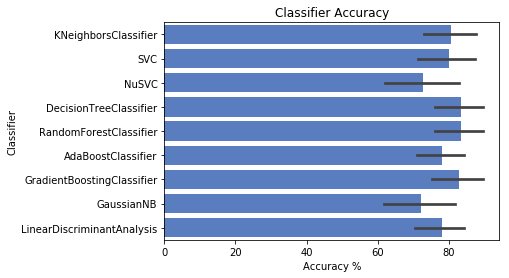

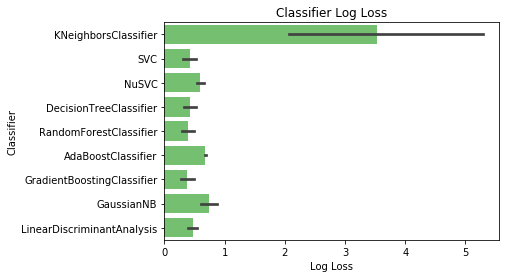

In [15]:
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()